# Multivariate stochastic differential equations with `Bridge`

This `IJulia` script gives a tour for my package `Bridge` with focus on multivariate stochastic differential equations. I use `Makie.jl` for the visualisations. 

## Installation

To run this `IJulia` script install Bridge and checkout the master branch to run.

In [44]:
# Pkg.add("Bridge")
# Pkg.checkout("Bridge")

The installation of `Makie` is a bit tricky and is detailed in the `README.md` file of `Makie`.

## Setting the scene

The next few lines load the needed packages and some scripts.

In [2]:
using Bridge, StaticArrays, Makie, Bridge.Models, Colors, GeometryTypes

In [28]:
include("../extra/makie.jl");

Some definitions. 

In [4]:
srand(5)
sphere = Sphere(Point3f0(0,0,0), 1.0f0)
circle = Sphere(Point2f0(0,0), 1.0f0)
perspective = @SArray Float32[0.433 0.901 -0.0 1.952; -0.237 0.114 0.965 -20.43; 0.869 -0.418 0.263 -90.271; 0.0 0.0 0.0 1.0];

## Time

`Bridge` mostly works with fix time grid methods. To get started, define a grid of time points `tt` say in the interval `[0, 5]` on which you want to simulate the process.

In [5]:
T = 5.00
n = 10001 # total length
dt = T/(n - 1)
tt = 0.0:dt:T
;

## Space

`Bridge` interacts nicely with `StaticArrays`. We use `SVector{3,Float64}` for points in 3d space.
In `Bridge.Models` the alias `ℝ{3} == SVector{3,Float64}` is defined. Because I often use MCMC methods and have to sample thousands of solutions, I try to make sure the functions are fast and have minimal overhead. Using `SVector`s helps alot.


In [6]:
ℝ{3}

SVector{3,Float64}

## 3D Wiener process or Brownian motion

`Bridge.jl` is a statistical toolbox for diffusion processes and stochastic differential equations.
The simplest diffusion process is a Brownian motion. The distribution and concept of a Brownian motion is represented by the object `Wiener{T}()` where `T` is the value type. As long as `randn(T)` is defined, `Wiener{T}()` can be sampled. 

In [7]:
Wiener{Float64}()
Wiener{Complex{Float64}}()

Bridge.Wiener{Complex{Float64}}()

But now for 3d Brownian motion...

In [8]:
Wiener{ℝ{3}}()

Bridge.Wiener{SVector{3,Float64}}()

Use `sample` to exactly sample a 3d `Wiener` process on at the time points `tt`.

In [9]:
W = sample(tt, Wiener{ℝ{3}}())

Bridge.SamplePath{SVector{3,Float64}}([0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045  …  4.9955, 4.996, 4.9965, 4.997, 4.9975, 4.998, 4.9985, 4.999, 4.9995, 5.0], SVector{3,Float64}[[0.0, 0.0, 0.0], [0.0327429, 0.00583326, -0.00555515], [0.0581026, -0.0293756, -0.0256774], [0.045495, -0.0523616, -0.0271225], [0.0546075, -0.0207844, -0.0123186], [0.047648, -0.0185863, 0.0070987], [0.052417, -0.0398085, -0.0022569], [0.069798, -0.0385233, -0.0138994], [0.0959046, -0.0322122, 0.0603608], [0.0990595, -0.0609897, 0.0192606]  …  [-0.631677, -0.949839, -0.773298], [-0.640412, -0.972126, -0.75062], [-0.66116, -0.958156, -0.798044], [-0.698215, -0.926062, -0.784364], [-0.684498, -0.938696, -0.738218], [-0.714381, -0.926597, -0.75491], [-0.727137, -0.966003, -0.763791], [-0.77403, -0.978722, -0.755095], [-0.749953, -0.996518, -0.733079], [-0.754657, -1.0043, -0.721557]])

The function `sample` returns a `SamplePath` `X`.
`SamplePath` is the time series object of `Bridge.jl`, basically a `struct` with a vector of time points `X.tt` and a vector of locations `X.yy`.

The script `extra/makie.jl` defines a recipe for plotting `SamplePath`s with `Makie`.

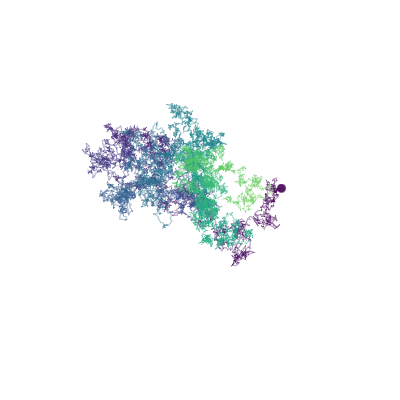

In [39]:
# Figure 1: Brownian motion path

scene = Scene(resolution = (200, 200))
lines(W, linewidth = 0.5, color = viridis(n))
scatter([W.yy[1]], markersize = 0.09, marker = circle, color = viridis(1)) # starting point
center!(scene)

*Figure 1.* Brownian motion in 3d. Colors indicate progress of time.

## Lorenz system of ordinary differential equations

`Bridge.jl` is mostly concerned with stochastic differential equations, but we can also solve ordinary differiential equations
$$
\frac{d}{dt} x(t) = F(t, x(t)). 
$$

As a stochastic differential equation can be seen as ordinary differential equation with noise, let's start with an ordinary one and add noise in a second step. 

The Lorenz system is famous and nice looking 3d system of ordinary differential equations. 

In [11]:
F(t, x, s = 10.0, ρ = 28.0, β = 8/3) = ℝ{3}(s*(x[2] - x[1]), x[1]*(ρ - x[3]) - x[2], x[1]*x[2] - β*x[3])
x0 = ℝ{3}(1.508870, -1.531271, 25.46091)
;

Note that $F(t, x)$ returns a 3d vector, we have written the Lorenz system as vector valued differential equation.

$s$, $\rho$ and $\beta$ are parameters governing the system. With following parameters chosen by Lorenz the system shows chaotic behaviour:

In [12]:
s0 = 10
ρ0 = 28.0
β0 = 8/3
θ0 = ℝ{3}(s0, ρ0, β0)
;

Compute a solution with 
`solve`. The argument `BS3()` tells `solve` to use an order 3 Bogacki–Shampine method. 

In [13]:
U, err = solve(BS3(), tt, x0, F)
round(err,5)

0.00077

In [14]:
F2(t,x,_) = F(t,x)
solve!(BS3(), F2, U, x0, nothing)

(Bridge.SamplePath{SVector{3,Float64}}([0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045  …  4.9955, 4.996, 4.9965, 4.997, 4.9975, 4.998, 4.9985, 4.999, 4.9995, 5.0], SVector{3,Float64}[[1.50887, -1.53127, 25.4609], [1.49371, -1.52859, 25.4258], [1.47865, -1.5259, 25.3908], [1.46367, -1.5232, 25.3559], [1.44878, -1.5205, 25.321], [1.43398, -1.5178, 25.2861], [1.41926, -1.5151, 25.2514], [1.40463, -1.51239, 25.2167], [1.39009, -1.50967, 25.182], [1.37563, -1.50696, 25.1474]  …  [0.50237, 0.918763, 9.50489], [0.504457, 0.922959, 9.49246], [0.506555, 0.927176, 9.48004], [0.508663, 0.931413, 9.46764], [0.510782, 0.935671, 9.45527], [0.512912, 0.93995, 9.44291], [0.515053, 0.94425, 9.43057], [0.517204, 0.94857, 9.41825], [0.519366, 0.952912, 9.40594], [0.52154, 0.957274, 9.39366]]), 0.000768832133378928)

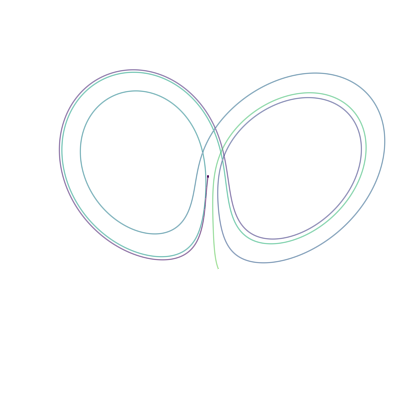

In [38]:
# Figure 2: Solution of the Lorenz system

scene = Scene(resolution = (200, 200))
lines(U, linewidth = 0.8, color = viridis(n))
scatter([U.yy[1]], markersize=0.4, marker = circle, color = viridis(1))
center!(scene)
set_perspective!(scene, perspective)

*Figure 2.* A solution of the deterministic Lorenz system. 

## Stochastic Lorenz system

A corresponding stochastic differential equation has the following form
$$
    \frac{d}{dt} X(t) = F(t, X(t)) + \sigma(t,X(t)) W(t). 
$$
For the example, we choose $\sigma = 5I$.


In [16]:
σ = (t,x)->5I
X = solve(EulerMaruyama(), x0, W, (F, σ))
;

As the driving Brownian motion path provides a set of time points `W.tt`, the argument `tt` is dropped. `solve` has also an in-place version `solve!`.

In [45]:
@time solve!(EulerMaruyama(), X, x0, W, (F, σ));

  0.000367 seconds (4 allocations: 160 bytes)


Note the solver is quite efficient.

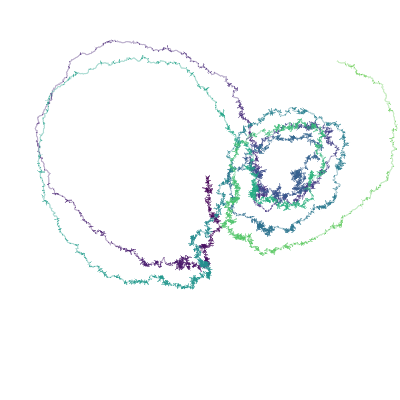

In [37]:
# Figure 3: Sample path

scene = Scene(resolution = (200, 200))
lines(X, linewidth = 0.5, color = viridis(n))
scatter([X.yy[1]], markersize=0.09, marker = circle, color = viridis(1))
center!(scene)
set_perspective!(scene, perspective)

*Figure 3.* Sample of the solution of the stochastic Lorenz system.

## Parameter inference for the stochastic Lorenz system

The likelihood for the parameter $\theta = (s, \rho, \beta)$ is given by Girsanov's theorem.
The stochastic Lorenz system is defined in `Bridge.Model` and takes a parameter triple `θ`.


In [20]:
function loglikelihood(θ, θref, X) 
    P = Lorenz(θ, SDiagonal(5.0, 5.0, 5.0))
    Pref = Lorenz(θref, SDiagonal(5.0, 5.0, 5.0)) # Reference measure
    girsanov(X, P, Pref)
end

loglikelihood (generic function with 1 method)

Choose a reference measure. We only estimate `ρ` and `β`.

In [47]:
θref = s0, Ρ[end÷2], Β[end÷2] 
@show θref;

θref = (10, 27.95, 2.98)


In [32]:
S = 9.0:0.05:11.0
Ρ = 26:0.05:30
Β = 2.0:0.02:4.0
llsurface = [loglikelihood((s0, ρ, β), θref, X) for ρ in Ρ, β in Β];

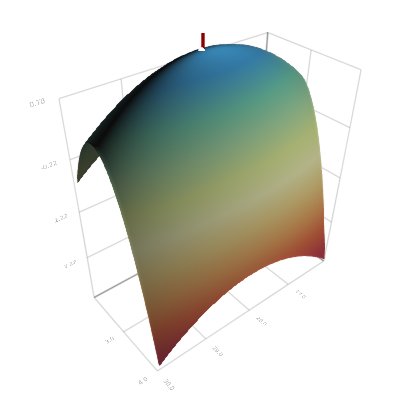

In [42]:
# Figure 4: Likelihood surface

scene = Scene(resolution = (200, 200))
llsurfaces = (llsurface - mean(llsurface))/std(llsurface)
llsurfaces0 = llsurfaces[first(searchsorted(Ρ,ρ0)), first(searchsorted(Β,β0))]
surface(Ρ, Β, llsurfaces, colormap = :Spectral)

l = Point3f0(ρ0, β0, 0.0)
u = Point3f0(ρ0, β0, 1.2*llsurfaces0)
lines(Point3f0[l,(u+2l)/3, (2u+l)/3, u], linewidth=3.5, color=:darkred)

i,j = ind2sub(size(llsurfaces),indmax(llsurfaces))
scatter([Point3f0(Ρ[i],Β[j], maximum(llsurfaces))], markersize=0.1, marker = circle, color = :white)
axis(Ρ[1]:1.0:Ρ[end], Β[1]:1.0:Β[end], minimum(llsurfaces):1.0:maximum(llsurfaces))
center!(scene)
set_perspective!(scene, Float32[-0.7788 0.6272 -0.0 20.1757; -0.3824 -0.4748 0.7926 13.1915; 0.4972 0.6173 0.6097 -23.9617; 0.0 0.0 0.0 1.0])


*Figure 4*. (Log-) likelihood surface. A line marks the true parameter value, a circle the maximum likelihood estimate

## Markov chain Monte Carlo

In my work I am interested in Bayesian methods for inference for stochastic differential equations.
To compute the posterior distribution of the parameters on naturally employes Markov Chain Monte Carlo (MCMC) methods.

Julia is a very good match for MCMC computations: They are sequential and cannot be vectorized. In programming languages with slow loops this is a problem and probabilistic programming libraries are used.
For Julia, those too exists, but we may also just stay with Julia.


In [50]:
# MCMC sampler

logπ(s, ρ, β) = 1.0
function mcmc(X, logπ, θstart, θref; iterations = 10000)
    θ = θstart
    Θ = [θ]
    ll = -Inf
    lπ = logπ(θ...)
    for i in 1:iterations
        θᵒ = θ + 0.1*randn(ℝ{3})
        lπᵒ = logπ(θᵒ...)
        llᵒ = loglikelihood(θᵒ, θref, X)
        if rand() < exp(llᵒ - ll + lπᵒ - lπ)
            θ, lπ, ll = θᵒ, lπᵒ, llᵒ 
        end
        push!(Θ, θ)
    end
    Θ
end

# MCMC experiment

θref = S[end÷2], Ρ[end÷2], Β[end÷2] 
@time Θ = mcmc(X, logπ, ℝ{3}(9.,30.,2.0), θref; iterations = 10000)
@show mean(Θ)
@show θ0
;

  9.618450 seconds (120.96 k allocations: 4.632 MiB, 0.80% gc time)
mean(Θ) = [11.0041, 28.0243, 2.71512]
θ0 = [10.0, 28.0, 2.66667]


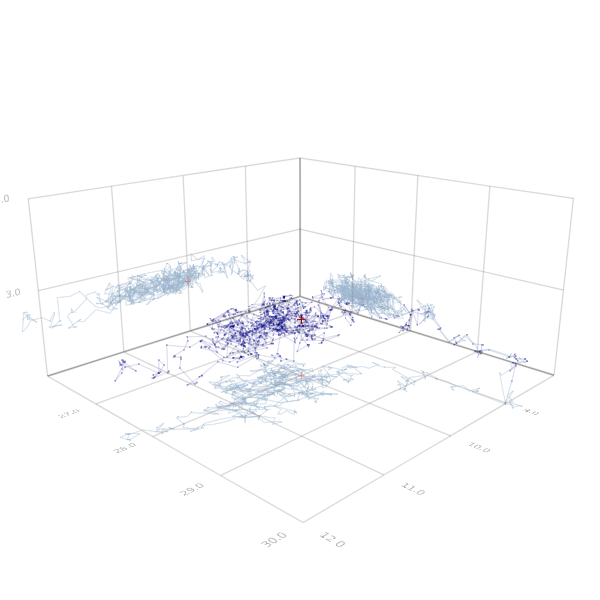

In [43]:
# Figure 5: Traceplot

scene = Scene(resolution = (300, 300))
Θs = [Point3f0(Θ[i]+0.01randn(ℝ{3})) for i in 1:1:1000] # subsample
scatter(Θs, markersize=0.02, marker = circle, color=RGBA(0.0, 0.0, 0.5, 0.3) )
lines(Θs, linewidth=0.5, color=RGBA(0.0, 0.0, 0.5, 0.3) )
#lines(Θ[end-10000:10:end], linewidth=0.2, color=:black)

for i in 1:3
    p = ℝ{3}(ntuple(n->n!=i,3))
    lines([Θs[i].*p .+ ℝ{3}(S[1],Ρ[1],Β[1]).*(1 .- p) for i in 1:length(Θs)], 
        linewidth=0.4, color=RGB(0.6,0.7,0.8) )
end
scatter([ℝ{3}(s0, ρ0, β0)], markersize=0.1, marker = '+', color = :darkred)
Ps = [ℝ{3}(ntuple(n->n!=i,3)) for i in 1:3]
scatter([ℝ{3}(s0, ρ0, β0).*p  .+ ℝ{3}(S[1],Ρ[1],Β[1]).*(1 .- p) for p in Ps], 
    markersize=0.08, marker = '+', color = RGB(0.8,0.5,0.5))
axis(8.0:1.0:12.0, Ρ[1]:1.0:Ρ[end], Β[1]:1.0:Β[end])


center!(scene)


*Figure 5.* Samples of the MCMC chain for the posterior distribution (black) and true value (red). Projections on the $s$-$\rho$-plane, the $\rho$-$\beta$-plane and the $\beta$-$s$-plane in gray, gray-red.